# Imports


In [11]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

# Loading and cleaning data

In [8]:
# Load data
DATA_PATH = "/Users/teymour/Desktop/cmor438/data/diamond-prices.csv"
df = pd.read_csv(DATA_PATH)

# Clean data (drop NA)
df = df.dropna()

# Data exploration

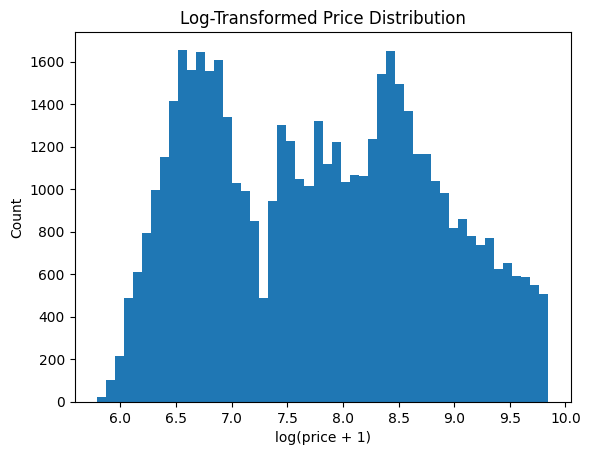

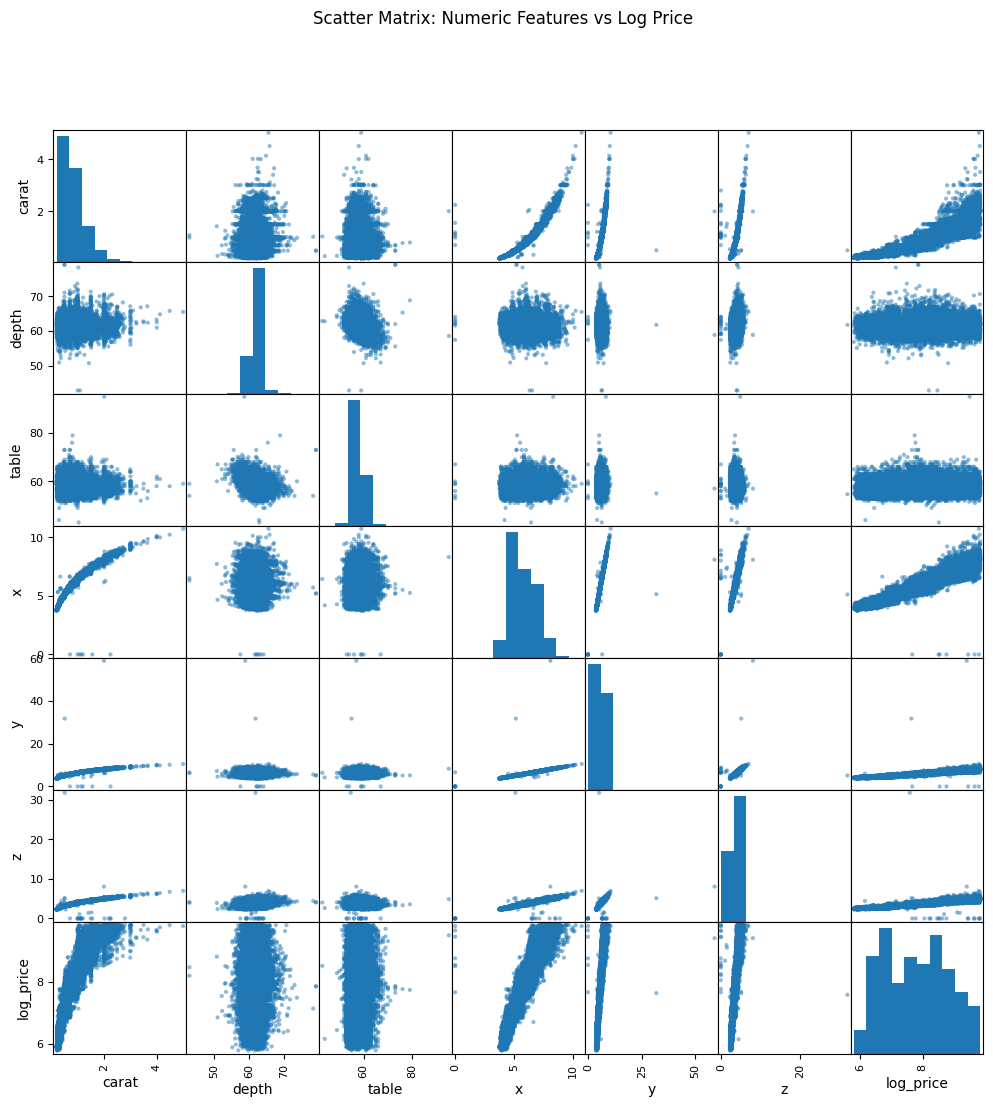

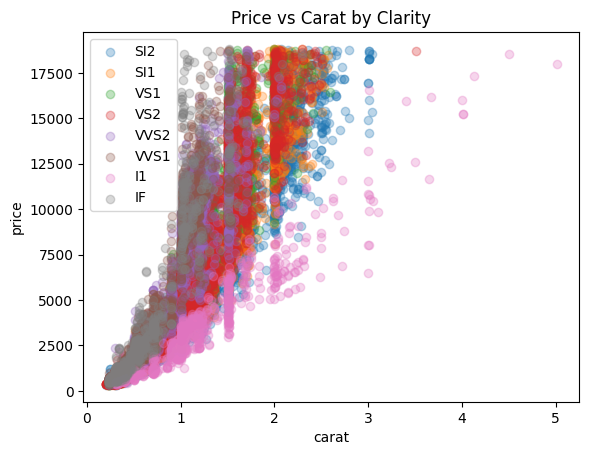

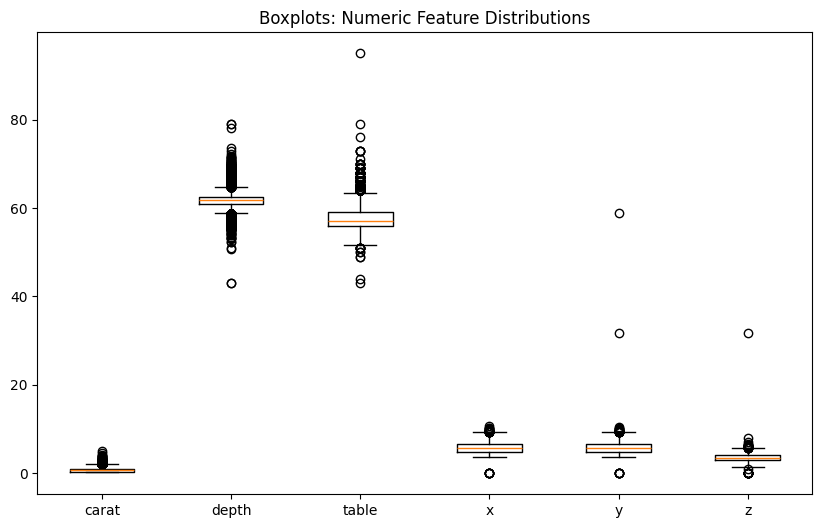

In [12]:
# explore log-transformed target distribution
plt.figure()
plt.hist(np.log1p(df['price']), bins=50)
plt.xlabel('log(price + 1)')
plt.ylabel('Count')
plt.title('Log-Transformed Price Distribution')
plt.show()

# scatter matrix of key numeric features against log(price)
subset = df[['carat','depth','table','x','y','z']].copy()
subset['log_price'] = np.log1p(df['price'])
scatter_matrix(subset, figsize=(12, 12), diagonal='hist', alpha=0.5)
plt.suptitle('Scatter Matrix: Numeric Features vs Log Price')
plt.show()

# interaction: price vs carat colored by clarity levels
for level in df['clarity'].unique():
    mask = df['clarity'] == level
    plt.scatter(df.loc[mask, 'carat'], df.loc[mask, 'price'], label=level, alpha=0.3)
plt.xlabel('carat')
plt.ylabel('price')
plt.title('Price vs Carat by Clarity')
plt.legend()
plt.show()

# boxplots for numeric feature distributions to reveal skew and outliers
numeric = ['carat','depth','table','x','y','z']
plt.figure(figsize=(10, 6))
plt.boxplot([df[f] for f in numeric], labels=numeric)
plt.title('Boxplots: Numeric Feature Distributions')
plt.show()


# Gradient boosting model

In [13]:
# feature engineering
df['volume'] = df['x'] * df['y'] * df['z']

# prepare features and target
numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z', 'volume']
categorical_features = ['cut', 'color', 'clarity']
X = pd.get_dummies(df[numeric_features + categorical_features], drop_first=True)
y = df['price']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# train Gradient Boosting Regressor
model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# Model evaluation

Buffer Accuracy (±$500): 0.7830
Test MSE: 650580.03
Test MAE: 420.61
Test R²: 0.958


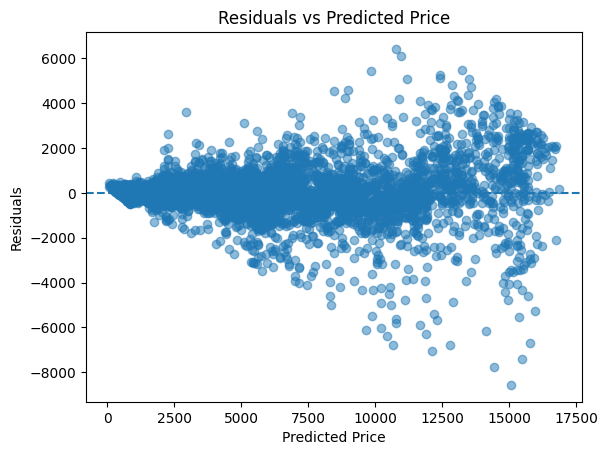

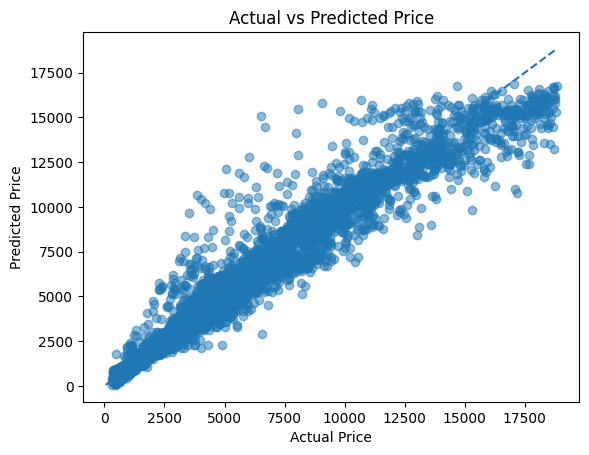

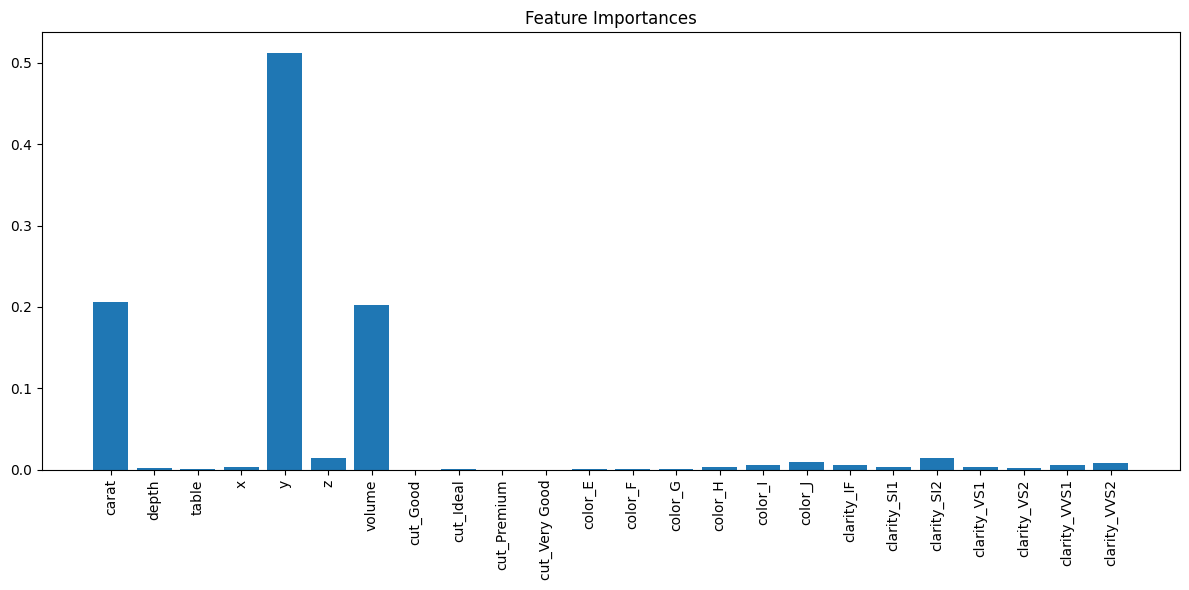

In [14]:
y_true = y_test

# metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
buffer_accuracy = np.mean(np.abs(y_true - y_pred) <= 500)

print(f"Buffer Accuracy (±$500): {buffer_accuracy:.4f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.3f}")

# residuals vs predicted
residuals = y_true - y_pred
plt.figure()
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Price")
plt.show()

# actual vs predicted
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.figure()
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot(lims, lims, '--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

# feature importances
plt.figure(figsize=(12, 6))
importances = model.feature_importances_
feature_names = X_train.columns
plt.bar(feature_names, importances)
plt.xticks(rotation=90)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


# Discussion of results

R² = 0.958, MAE = 420.61, buffer accuracy = 78.30%. Residuals remain centered around zero with less spread at high prices compared to linear regression. Feature importances still highlight carat and y but z also seems signifcant here, reflecting the model’s ability to combine multiple size dimensions. Gradient boosting outperforms linear regression by capturing nonlinear relationships within the data, so the results here are not suprising. We do see interesting residual behavior though, with residuals fanning out at higher predicted values, likely due to data sparisty.